In [1]:
# the following python script is necessary to run this notebook.
# it is available here: 
# https://github.com/jbloomlab/SARS2_RBD_Ab_escape_maps/blob/main/bindingcalculator.py
from bindingcalculator import BindingCalculator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pickle
import torch

## Load binding calculator

In [3]:
# instantiate binding calculator based on escape data
# https://github.com/jbloomlab/SARS2_RBD_Ab_escape_maps/

url = 'https://raw.githubusercontent.com/jbloomlab/' + \
      'SARS2_RBD_Ab_escape_maps/main/processed_data/escape_calculator_data.csv'
metric = 'sum of mutations at site' # metric='mean of mutations at site'
bindcalc = BindingCalculator(csv_or_url=url,
                             eliciting_virus='SARS-CoV-2',
                             source_lab='all',
                             neutralizes_Omicron='either',
                             metric=metric,
                             mutation_escape_strength=2.0)
sites = bindcalc.sites
print("A total of {} RBD sites have escape data".format(len(bindcalc.sites)))
print("Sites span {} to {}".format(min(sites), max(sites)))

A total of 201 RBD sites have escape data
Sites span 331 to 531


In [4]:
# ingest pyro-cov inferences
mutations = pd.read_csv('../paper/mutations.tsv', sep='\t')
# filter to S gene only
mutations = mutations[[m[:2]=='S:' for m in mutations.mutation]]
print("Our model considers {} mutations in the S gene.".format(len(mutations)))
# filter to sites that we have escape data for
mutations = mutations[[int(m[3:-1]) in sites for m in mutations.mutation]]
sites = list(set([int(m[3:-1]) if int(m[3:-1]) in sites else None for m in mutations.mutation]))
print("Of these, {} mutations have escape data:".format(len(sites)))
print(sorted(sites))

Our model considers 415 mutations in the S gene.
Of these, 47 mutations have escape data:
[339, 344, 346, 352, 356, 357, 370, 371, 373, 375, 376, 384, 385, 394, 405, 408, 411, 414, 415, 417, 439, 440, 445, 446, 449, 450, 452, 453, 459, 460, 470, 477, 478, 479, 481, 483, 484, 490, 493, 494, 496, 498, 499, 501, 505, 520, 522]


### All lineage analysis

In [5]:
results_dir = '../results/'
filename = 'mutrans.svi.3000.1.50.coef_scale=0.05.reparam-localinit.full.10001.0.05.0.1.10.0.200.6.None..pt'
fit = torch.load(results_dir + filename, map_location=torch.device('cpu'))

coef = fit['median']['coef'].data.cpu()

features = torch.load(results_dir + 'features.3000.1.pt', map_location=torch.device('cpu'))

clades = features['clades']
clade_to_lineage = features['clade_to_lineage']
mutations = features['aa_mutations']
features = features['aa_features'].data.cpu().float()

rbd = []
for m in mutations:
    if m[:2] != 'S:':
        rbd.append(0)
        continue

    pos = int(m[3:-1])
    if pos >= 319 and pos <= 541:
        rbd.append(1)
    else:
        rbd.append(0)

rbd = torch.tensor(rbd).bool()
rbd_mutations = np.array(mutations)[rbd].tolist()
rbd_features = features[:, rbd].data.numpy()
rbd_coef = coef[rbd].data.numpy()

print("rbd_features", rbd_features.shape)
print("rbd_coef", rbd_coef.shape)

rbd_features (3000, 68)
rbd_coef (68,)


In [6]:
print(len(rbd_mutations), rbd_coef.shape, rbd_features.shape)

common_mutations = []
for m in rbd_mutations:
    m = int(m[3:-1])
    if m in sites:
        common_mutations.append(1)
    else:
        common_mutations.append(0)
common_mutations = np.array(common_mutations, dtype=bool)   
print(common_mutations.sum(), common_mutations.shape[0])

68 (68,) (3000, 68)
67 68


In [7]:
rbd_mutations = np.array(rbd_mutations)[common_mutations]
rbd_features = rbd_features[:, common_mutations]

at_least_one_rbd_mutation = rbd_features.sum(-1) > 0
rbd_features = np.array(rbd_features[at_least_one_rbd_mutation], dtype=bool)
print(rbd_features.shape)

rbd_pred = 0.01 * rbd_features @ rbd_coef[common_mutations]
print(rbd_pred.shape)

(1701, 67)
(1701,)


In [8]:
binding = []

for variant in rbd_features:
    mutations = rbd_mutations[variant]
    mutations = [int(m[3:-1]) for m in mutations]
    assert len(mutations) == len(set(mutations))
    binding.append( 1 - bindcalc.binding_retained(mutations) )
        
print(len(binding))

1701


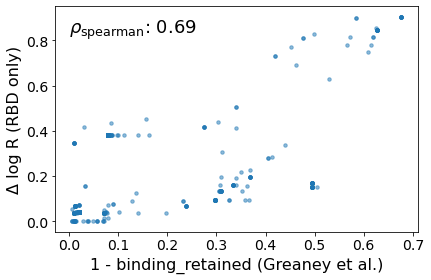

In [9]:
spearman = stats.spearmanr(binding, rbd_pred)[0]

plt.scatter(binding, rbd_pred, alpha=0.5, s=12)
plt.xlabel("1 - binding_retained (Greaney et al.)", fontsize=16)
plt.ylabel("Δ log R (RBD only)", fontsize=16)
plt.text(0.0, 0.83, "$\\rho_{\\rm spearman}$" +": {:.2f}".format(spearman), fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=14)
    
plt.tight_layout()
plt.savefig("binding_retained.png")
plt.show()